In [1]:
import sys
print(sys.executable)

C:\Users\Mudassarali.Sayyed\AppData\Local\anaconda3\envs\mlops\python.exe


In [2]:
!python --version

Python 3.9.19


In [3]:
import pandas as pd
import numpy as np

### mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts --host 0.0.0.0 --port 5000

In [4]:
import os   # os module iteract with OS, 
os.environ['MLFLOW_TRACKING_URI'] = 'http://localhost:5000/'


In [5]:
import mlflow
mlflow.set_tracking_uri(os.environ['MLFLOW_TRACKING_URI'])

C:\Users\Mudassarali.Sayyed\AppData\Local\anaconda3\envs\mlops\lib\site-packages\pydantic\_internal\_fields.py:160: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
C:\Users\Mudassarali.Sayyed\AppData\Local\anaconda3\envs\mlops\lib\site-packages\pydantic\_internal\_config.py:334: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [7]:
mlflow.create_experiment(name='example-mlflow-tut2')

'2'

In [8]:
mlflow.set_experiment('example-mlflow-tut')

<Experiment: artifact_location='file:///D:/New folder/artifacts/1', creation_time=1714536250064, experiment_id='1', last_update_time=1714536250064, lifecycle_stage='active', name='example-mlflow-tut', tags={}>

In [9]:
with mlflow.start_run(run_name='first-run') as mlops_run:
    mlflow.log_metric('Test mean absolute error', 0.60)
    mlflow.log_param('n_estimators', 10)

In [10]:
!pip install fastapi
from fastapi import FastAPI

In [11]:
def load_data(path):
    data = pd.read_csv(path)
    return data

In [13]:
# df = pd.read_csv('example.csv', nrows=2)
# df = pd.read_csv('example.csv').sample(n=1000)  ## for Large CSV file
data = load_data('https://raw.githubusercontent.com/TripathiAshutosh/dataset/main/banking.csv').sample(n=1000)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 34849 to 34663
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             1000 non-null   int64  
 1   job             1000 non-null   object 
 2   marital         1000 non-null   object 
 3   education       1000 non-null   object 
 4   default         1000 non-null   object 
 5   housing         1000 non-null   object 
 6   loan            1000 non-null   object 
 7   contact         1000 non-null   object 
 8   month           1000 non-null   object 
 9   day_of_week     1000 non-null   object 
 10  duration        1000 non-null   int64  
 11  campaign        1000 non-null   int64  
 12  pdays           1000 non-null   int64  
 13  previous        1000 non-null   int64  
 14  poutcome        1000 non-null   object 
 15  emp_var_rate    1000 non-null   float64
 16  cons_price_idx  1000 non-null   float64
 17  cons_conf_idx   1000 non-null   f

In [15]:
def data_cleaning(data):
    print("na values available in data \n")
    print(data.isna().sum())
    data = data.dropna()
    print("after droping na values \n")
    print(data.isna().sum())
    return data

In [16]:
def preprocessing(data):
    data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
    data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
    data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])
    
    cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
    for var in cat_vars:
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(data[var], prefix=var)
        data1=data.join(cat_list)
        data=data1

    cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
    data_vars=data.columns.values.tolist()
    to_keep=[i for i in data_vars if i not in cat_vars]
    
    final_data=data[to_keep]
    
    
    final_data.columns = final_data.columns.str.replace('.','_')
    final_data.columns = final_data.columns.str.replace(' ','_')
    return final_data

In [17]:
def train_test_split(final_data):
    from sklearn.model_selection import train_test_split
    X = final_data.loc[:, final_data.columns != 'y']
    y = final_data.loc[:, final_data.columns == 'y']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify = y, random_state=47)
    return X_train, X_test, y_train, y_test

In [18]:
def over_sampling_target_class(X_train, y_train):
    ### Over-sampling using SMOTE 
    from imblearn.over_sampling import SMOTE
    os = SMOTE(random_state=0)

    columns = X_train.columns
    os_data_X,os_data_y=os.fit_resample(X_train, y_train)

    os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
    os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
    # we can Check the numbers of our data
    print("length of oversampled data is ",len(os_data_X))
    print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
    print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
    print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
    print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))
    
    X_train = os_data_X
    y_train = os_data_y['y']
 
    return X_train, y_train

In [19]:
def training_basic_classifier(X_train,y_train):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=101)
    model.fit(X_train, y_train)
    
    return model

In [20]:
def predict_on_test_data(model,X_test):
    y_pred = model.predict(X_test)
    return y_pred

In [21]:
def predict_prob_on_test_data(model,X_test):
    y_pred = model.predict_proba(X_test)
    return y_pred

In [22]:
def get_metrics(y_true, y_pred, y_pred_prob):
    from sklearn.metrics import accuracy_score,precision_score,recall_score,log_loss
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    entropy = log_loss(y_true, y_pred_prob)
    return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2), 'entropy': round(entropy, 2)}

In [40]:
def create_roc_auc_plot(clf, X_data, y_data):
    import matplotlib.pyplot as plt
    from sklearn import metrics
    metrics.RocCurveDisplay.from_estimator(clf, X_data, y_data) 
    plt.savefig('roc_auc_curve.png')

In [45]:
def create_confusion_matrix_plot(clf, X_test, y_test):
    import matplotlib.pyplot as plt
    from sklearn.metrics import ConfusionMatrixDisplay
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
    plt.savefig('confusion_matrix.png')

In [25]:
def hyper_parameter_tuning(X_train, y_train):
    # define random parameters grid
    n_estimators = [5,21,51,101] # number of trees in the random forest
    max_features = ['auto', 'sqrt'] # number of features in consideration at every split
    max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
    min_samples_split = [2, 6, 10] # minimum sample number to split a node
    min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
    bootstrap = [True, False] # method used to sample data points

    random_grid = {'n_estimators': n_estimators,
                    'max_features': max_features,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'bootstrap': bootstrap
                  }
    
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.ensemble import RandomForestClassifier
    classifier = RandomForestClassifier()
    model_tuning = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid,
                   n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
    model_tuning.fit(X_train, y_train)

    print ('Random grid: ', random_grid, '\n')
    # print the best parameters
    print ('Best Parameters: ', model_tuning.best_params_, ' \n')

    best_params = model_tuning.best_params_
    
    n_estimators = best_params['n_estimators']
    min_samples_split = best_params['min_samples_split']
    min_samples_leaf = best_params['min_samples_leaf']
    max_features = best_params['max_features']
    max_depth = best_params['max_depth']
    bootstrap = best_params['bootstrap']
    
    model_tuned = RandomForestClassifier(n_estimators = n_estimators, min_samples_split = min_samples_split,
                                         min_samples_leaf= min_samples_leaf, max_features = max_features,
                                         max_depth= max_depth, bootstrap=bootstrap) 
    model_tuned.fit( X_train, y_train)
    return model_tuned,best_params

In [26]:
cleaned_data = data_cleaning(data)

na values available in data 

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
after droping na values 

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64


In [28]:
final_data = preprocessing(cleaned_data)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(final_data)

In [31]:
!pip install imblearn
X_train, y_train = over_sampling_target_class(X_train, y_train)

   ---------------------------------------- 0.0/258.0 kB ? eta -:--:--
   -------------------------------------- - 245.8/258.0 kB 5.0 MB/s eta 0:00:01
   ---------------------------------------  256.0/258.0 kB 5.2 MB/s eta 0:00:01
   ---------------------------------------- 258.0/258.0 kB 2.6 MB/s eta 0:00:00
length of oversampled data is  1236
Number of no subscription in oversampled data 618
Number of subscription 618
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [32]:
model = training_basic_classifier(X_train,y_train)

In [33]:
y_pred = predict_on_test_data(model,X_test)

In [34]:
y_pred_prob = predict_prob_on_test_data(model,X_test) #model.predict_proba(X_test)

In [35]:
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)

In [36]:
print(run_metrics)

{'accuracy': 0.9, 'precision': 0.64, 'recall': 0.4, 'entropy': 0.21}


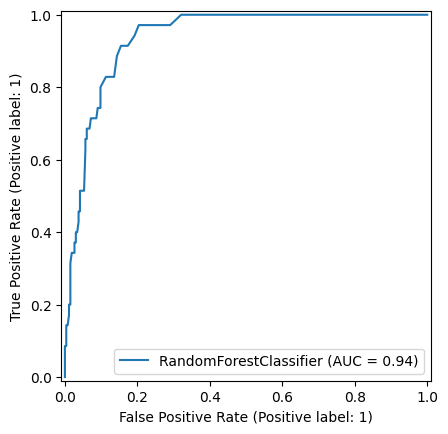

In [41]:
create_roc_auc_plot(model, X_test, y_test)

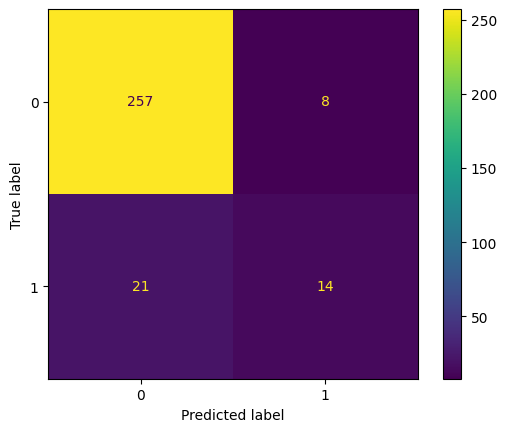

In [46]:
create_confusion_matrix_plot(model, X_test, y_test)

## MLFlow work Starts from here

In [47]:
experiment_name = "basic_classifier" ##basic classifier
run_name="term_deposit"
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)
print(run_metrics)

{'accuracy': 0.9, 'precision': 0.64, 'recall': 0.4, 'entropy': 0.21}


NameError: name 'create_experiment' is not defined

In [49]:
def create_experiment(experiment_name,run_name, run_metrics,model, confusion_matrix_path = None, 
                      roc_auc_plot_path = None, run_params=None):
    import mlflow
    #mlflow.set_tracking_uri("http://localhost:5000") #uncomment this line if you want to use any database like sqlite as backend storage for model
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run():
        
        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])
            
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])
        
        mlflow.sklearn.log_model(model, "model")
        
        if not confusion_matrix_path == None:
            mlflow.log_artifact(confusion_matrix_path, 'confusion_materix')
            
        if not roc_auc_plot_path == None:
            mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")
        
        mlflow.set_tag("tag1", "Random Forest")
        mlflow.set_tags({"tag2":"Randomized Search CV", "tag3":"Production"})
            
    print('Run - %s is logged to Experiment - %s' %(run_name, experiment_name))

In [50]:
create_experiment(experiment_name,run_name,run_metrics,model,'confusion_matrix.png', 'roc_auc_curve.png')

2024/05/01 17:00:11 INFO mlflow.tracking.fluent: Experiment with name 'basic_classifier' does not exist. Creating a new experiment.


Run - term_deposit is logged to Experiment - basic_classifier


In [51]:
import mlflow
experiment_name = "optimized model"
run_name="Random_Search_CV_Tuned_Model"
model_tuned,best_params = hyper_parameter_tuning(X_train, y_train)
run_params = best_params

y_pred = predict_on_test_data(model_tuned,X_test) #will return the predicted class
y_pred_prob = predict_prob_on_test_data(model_tuned,X_test) #model.predict_proba(X_test)
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Random grid:  {'n_estimators': [5, 21, 51, 101], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 21, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}  



C:\Users\Mudassarali.Sayyed\AppData\Local\anaconda3\envs\mlops\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
235 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Mudassarali.Sayyed\AppData\Local\anaconda3\envs\mlops\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Mudassarali.Sayyed\AppData\Local\anaconda3\envs\mlops\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\Mudassarali.Sayyed\AppData\Local\anaconda3\envs\mlops

In [52]:
run_metrics

{'accuracy': 0.91, 'precision': 0.64, 'recall': 0.46, 'entropy': 0.2}

In [53]:
for param in run_params:
    print(param, run_params[param])

n_estimators 21
min_samples_split 6
min_samples_leaf 1
max_features sqrt
max_depth 40
bootstrap True


In [54]:
create_experiment(experiment_name,run_name,run_metrics,model_tuned,'confusion_matrix.png', 'roc_auc_curve.png',run_params)


2024/05/01 17:03:31 INFO mlflow.tracking.fluent: Experiment with name 'optimized model' does not exist. Creating a new experiment.
C:\Users\Mudassarali.Sayyed\AppData\Local\anaconda3\envs\mlops\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\Mudassarali.Sayyed\AppData\Local\anaconda3\envs\mlops\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Run - Random_Search_CV_Tuned_Model is logged to Experiment - optimized model
